In [1]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from hydra import initialize, compose
from hydra.utils import instantiate
import torch
import matplotlib.pyplot as plt

Configure encoder to make predictions using weights from a previous training run:

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/best_encoder-v4.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("lensing_config", {
        "train.pretrained_weights=" + ckpt,
        "predict.weight_save_path=" + ckpt,
        "train.trainer.logger=null",
        "train.trainer.max_epochs=0",
        "+train.trainer.num_sanity_val_steps=0",
        })

Load in the test images:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
test_data = list(test_dl)

Load in encoder weights:

In [5]:
encoder = instantiate(cfg.encoder).cuda()
encoder_state_dict = torch.load(cfg.train.pretrained_weights)["state_dict"]
encoder.load_state_dict(encoder_state_dict)

<All keys matched successfully>

Make predictions on the 40 test images:

In [6]:
trainer = instantiate(cfg.predict.trainer)
test_preds = trainer.predict(encoder, dataloaders = test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
shear1_true = torch.zeros(len(test_data), 8, 8)
shear1_pred = torch.zeros(len(test_data), 8, 8)
shear2_true = torch.zeros(len(test_data), 8, 8)
shear2_pred = torch.zeros(len(test_data), 8, 8)

for i in range(len(test_data)):
    shear1_true[i] = test_data[i]['tile_catalog']['shear_1'].squeeze()
    shear1_pred[i] = test_preds[i]['shear_1'].squeeze()
    shear2_true[i] = test_data[i]['tile_catalog']['shear_2'].squeeze()
    shear2_pred[i] = test_preds[i]['shear_2'].squeeze()

Compute test MSE:

In [8]:
print(f'shear 1 test MSE = {((shear1_true - shear1_pred) ** 2).mean()}')
print(f'shear 2 test MSE = {((shear2_true - shear2_pred) ** 2).mean()}')

shear 1 test MSE = 3.6260393244447187e-05
shear 2 test MSE = 4.5487417082767934e-05


Shear maps for five of the test images:

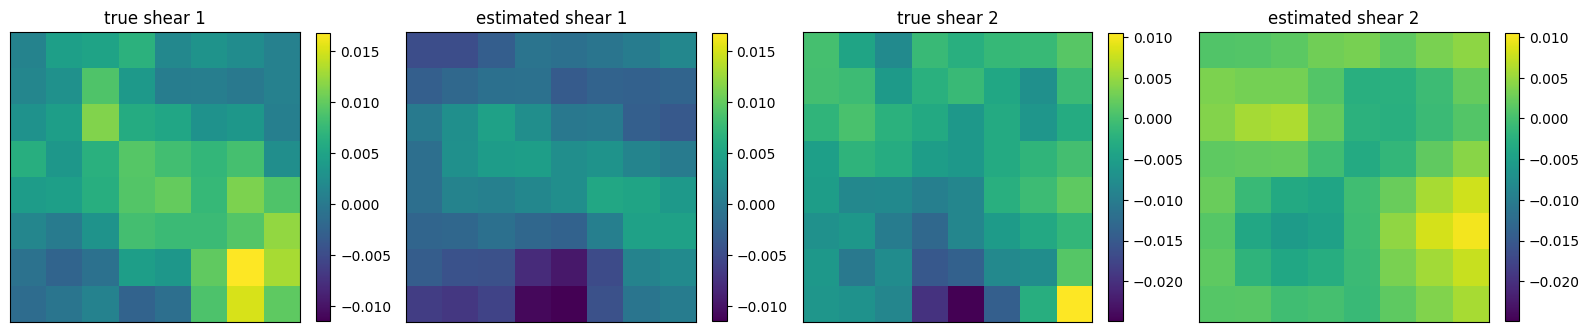

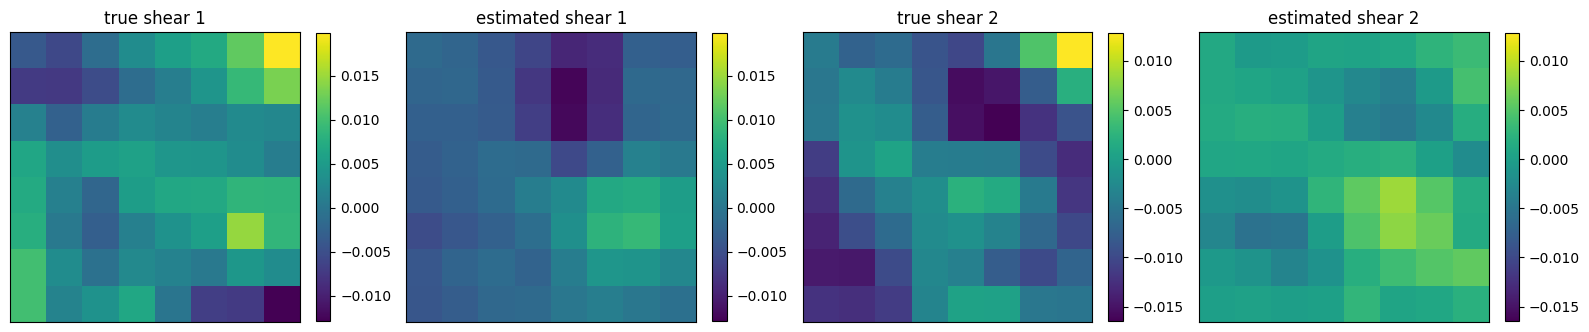

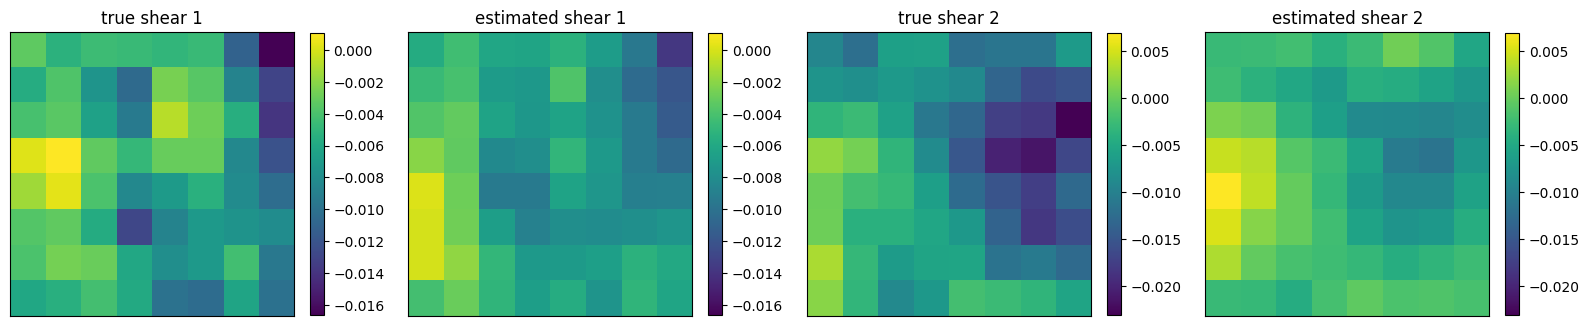

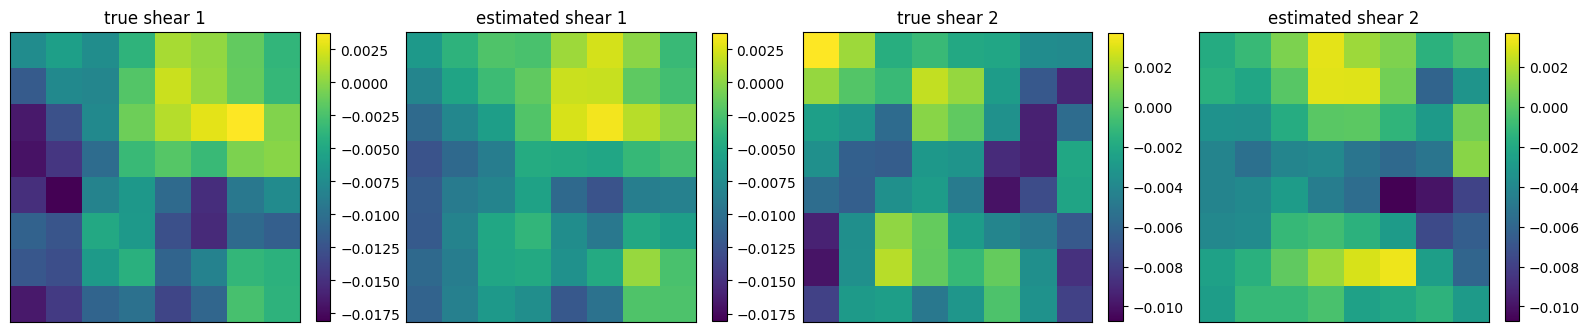

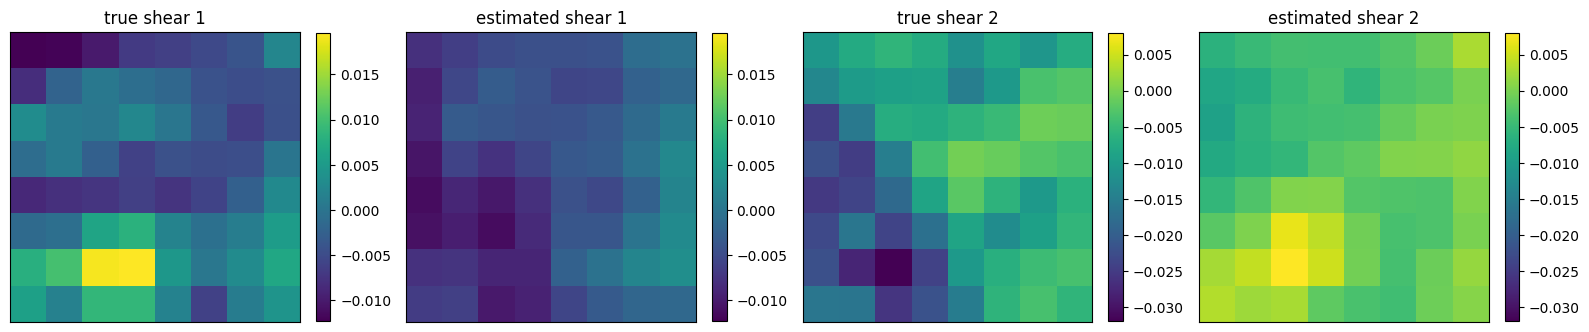

In [9]:
for img_index in range(5):

    fig, ax = plt.subplots(1,4,figsize=(16,4))
    
    vmin1 = min(shear1_true[img_index].min(), shear1_pred[img_index].min())
    vmax1 = max(shear1_true[img_index].max(), shear1_pred[img_index].max())
    vmin2 = min(shear2_true[img_index].min(), shear2_pred[img_index].min())
    vmax2 = max(shear2_true[img_index].max(), shear2_pred[img_index].max())
    
    true1 = ax[0].imshow(shear1_true[img_index], vmin = vmin1, vmax = vmax1)
    plt.colorbar(true1, fraction = 0.045)
    ax[0].set_title('true shear 1')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    pred1 = ax[1].imshow(shear1_pred[img_index], vmin = vmin1, vmax = vmax1)
    plt.colorbar(pred1, fraction = 0.045)
    ax[1].set_title('estimated shear 1')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    true2 = ax[2].imshow(shear2_true[img_index], vmin = vmin2, vmax = vmax2)
    plt.colorbar(true2, fraction = 0.045)
    ax[2].set_title('true shear 2')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    pred2 = ax[3].imshow(shear2_pred[img_index], vmin = vmin2, vmax = vmax2)
    plt.colorbar(pred2, fraction = 0.045)
    ax[3].set_title('estimated shear 2')
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    fig.tight_layout()

Scatterplots of true vs. estimated shear:

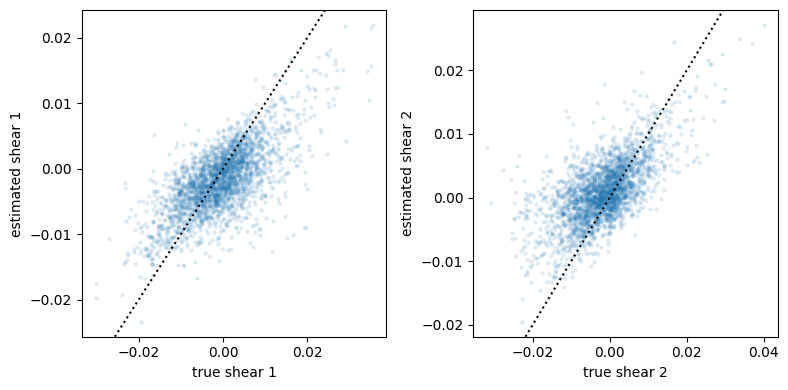

In [10]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
_ = ax[0].scatter(shear1_true.flatten(), shear1_pred.flatten(), alpha = 0.1, s = 5)
_ = ax[0].set_xlabel('true shear 1')
_ = ax[0].set_ylabel('estimated shear 1')
_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')

_ = ax[1].scatter(shear2_true.flatten(), shear2_pred.flatten(), alpha = 0.1, s = 5)
_ = ax[1].set_xlabel('true shear 2')
_ = ax[1].set_ylabel('estimated shear 2')
_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black')

fig.tight_layout()